# Deep Reinforcement Learning <em> in Action  </em>
## Ch 3 - Deep Q-Learning

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
from torch.autograd import Variable
from Gridworld import *
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

#### Helper functions

In [2]:
def running_mean(x, N=500):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

### Test model

In [3]:
def testModel(model, mode='static', display=True):
    epsilon = 0.05
    max_moves = 50
    win = False
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    if display: 
        print("Initial State:")
        print(test_game.display())
    status = 1
    #while game still in progress
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        #action_ = np.argmax(qval_) #take action with highest Q-value
        action = action_set[action_]
        if display: print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = Variable(torch.from_numpy(state_).float())
        if display: print(test_game.display())
        reward = test_game.reward()
        if reward == 10:
            status = 0
            win = True
            if display: print("You won! Reward: {}".format(reward,))
        elif reward == -10:
            status = 0
            if display: print("Game lost; stepped into the pit. Penalty: {}".format(reward,))
        i += 1 #If we're taking more than 10 actions, just stop, we probably can't win this game
        if (i > max_moves):
            if display: print("Game lost; too many moves.")
            break
    return win

In [4]:
def test_win_perc(model, max_games=1000):
    wins = 0
    for i in range(max_games):
        win = testModel(model, 'random', display=False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print("Win percentage: {}".format(win_perc))

# Deep Q-Learning

In [5]:
l1 = 64
l2 = 164
l3 = 150
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

loss_fn = torch.nn.MSELoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#reinforcement learning specific parameters
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


##### Without experience replay

In [6]:
epochs = 1000
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    status = 1
    #while game still in progress
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = (np.argmax(qval_))
        
        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        new_state = Variable(torch.from_numpy(new_state_).float())
        reward = game.reward()
        newQ = model(new_state.reshape(1,64)).data.numpy()
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval_[:]
        if reward == -1:
            update = (reward + (gamma * maxQ))
        else:
            update = reward
        y[0][action_] = update
        y = Variable(torch.from_numpy(y).float())
        loss = loss_fn(qval, y)
        print(i, loss.item())
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state = new_state
        if reward != -1:
            status = 0
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

999 0.12058652937412262


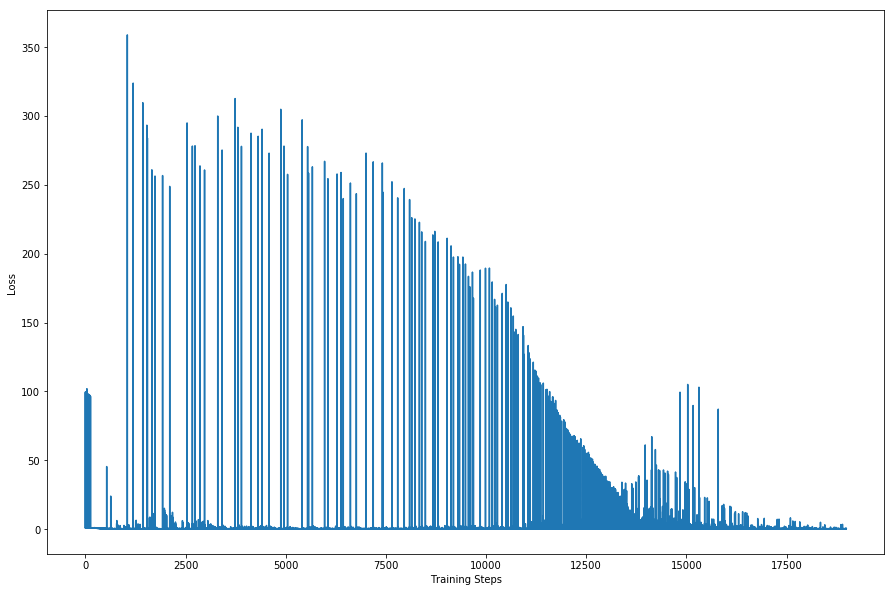

In [7]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(losses)
plt.savefig("dqn_1_loss_plot.pdf", format="pdf")

In [8]:
testModel(model, 'random')

Initial State:
[[' ' ' ' 'P' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' 'W' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 [' ' ' ' ' ' ' ']
 [' ' '-' 'W' ' ']]
You won! Reward: 10


True

In [6]:
l1 = 64
l2 = 200
l3 = 150
l4 = 100
l5 = 4

model2 = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4,l5)
)

loss_fn2 = torch.nn.MSELoss(size_average=False)

learning_rate2 = 1e-4
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate2)


#reinforcement learning specific parameters
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

### With experience replay

In [9]:
epochs = 1500
losses = []
batchSize = 40
buffer = 80
replay = []
max_moves = 75
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    status = 1
    mov = 0
    #while game still in progress
    while(status == 1):
        mov += 1
        qval = model2(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = (np.argmax(qval_))
        
        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        new_state = Variable(torch.from_numpy(new_state_).float())
        reward = game.reward()
        
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((state, action_, reward, new_state))
        else: #if buffer full, overwrite old values
            replay.pop(0)
            replay.append((state, action_, reward, new_state))
            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)
            X_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))
            y_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))
            h = 0
            for memory in minibatch:
                old_state, action_m, reward_m, new_state_m = memory
                #old_state = Variable(torch.from_numpy(old_state_).float())
                #new_state = Variable(torch.from_numpy(new_state_).float())
                old_qval = model2(old_state)
                #action = action_set[action_]
                newQ = model2(new_state_m).data.numpy()
                maxQ = np.max(newQ)
                y = torch.zeros((1,4))
                y[:] = old_qval[:]
                if reward == -1:
                    update = (reward_m + (gamma * maxQ))
                else:
                    update = reward_m
                y[0][action_m] = update
                X_train[h] = old_qval
                y_train[h] = Variable(y)
                h+=1
                
            
            #X_train = Variable(torch.from_numpy(np.asarray(X_train)).float())
            #y_train = Variable(torch.from_numpy(np.asarray(y_train)).float())
            
            loss = loss_fn2(X_train, y_train)
            print(i, loss.item())
            optimizer2.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer2.step()
            
            state = new_state
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

1499 8.275174140930176


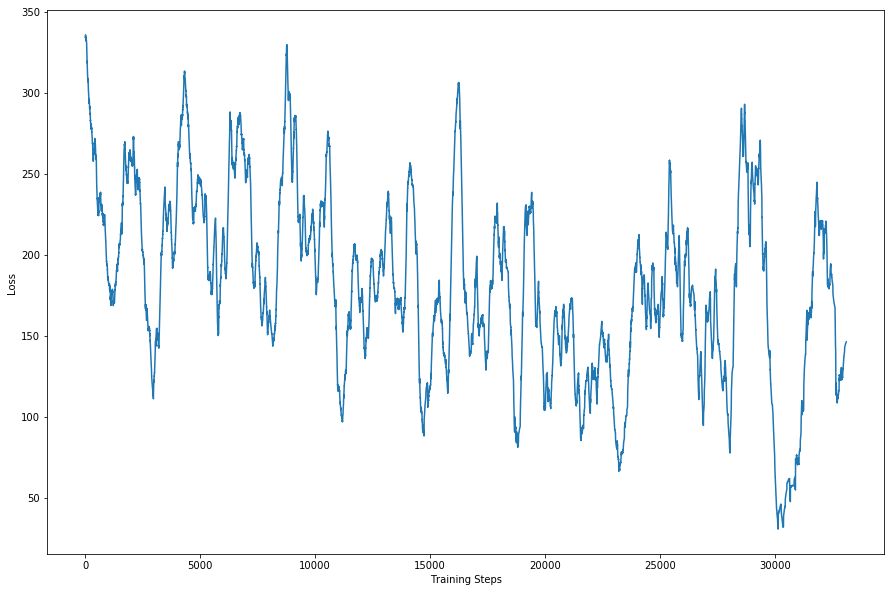

In [10]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(running_mean(losses))
#plt.savefig("dqn_3_loss_plot.pdf", format="pdf")

In [11]:
testModel(model2, 'random')

Initial State:
[['+' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'W' '-' ' ']]
Move #: 0; Taking action: l
[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'W' '-' ' ']]
You won! Reward: 10


True

### Test percentage game wins

In [12]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = testModel(model2, 'random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

Games played: 1000, # of wins: 405
Win percentage: 0.405


### With experience replay and target network

In [5]:
import copy

l1 = 64
l2 = 164
l3 = 150
l4 = 4

model3 = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4),
)

model3_ = copy.deepcopy(model3) #Target network

loss_fn3 = torch.nn.MSELoss(size_average=False)

learning_rate3 = 1e-3
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate3)


#reinforcement learning specific parameters
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [7]:
model3.to(device)
model3_.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=164, bias=True)
  (1): ReLU()
  (2): Linear(in_features=164, out_features=150, bias=True)
  (3): ReLU()
  (4): Linear(in_features=150, out_features=4, bias=True)
)

In [8]:
epochs = 5000
losses = []
batchSize = 250
buffer = 2000
replay = []
max_moves = 9
c = 500 #target network update step size
c_step = 0
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state = Variable(torch.from_numpy(state_).float()).cuda()
    status = 1
    mov = 0
    #while game still in progress
    while(status == 1):
        
        c_step += 1
        if c_step > c:
            model3_.load_state_dict(model3.state_dict())
            c_step = 0
        mov += 1
        
        qval = model3(state)
        qval_ = qval.cpu().data.numpy()
        #values, indices = torch.max(tensor, 0)
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
            #action_ = torch.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        new_state = Variable(torch.from_numpy(new_state_).float()).cuda()
        reward = game.reward()
        if mov > max_moves:
            reward = -5
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((state, action_, reward, new_state))
        else: #if buffer full, overwrite old values
            replay.pop(0)
            replay.append((state, action_, reward, new_state))
            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)
            X_train = Variable(torch.empty(batchSize, 4, dtype=torch.float)).cuda()
            y_train = Variable(torch.empty(batchSize, 4, dtype=torch.float)).cuda()
            h = 0
            for memory in minibatch:
                old_state, action_m, reward_m, new_state_m = memory
                old_qval = model3(old_state) #TARGET NETWORK!
                #newQ = model3_(new_state_m).cpu().data.numpy()
                newQ = model3_(new_state_m)
                #maxQ = np.max(newQ)
                maxQ = torch.max(newQ)
                y = torch.zeros((1,4))
                y[:] = old_qval[:]
                if reward == -1:
                    update = (reward_m + (gamma * maxQ))
                else:
                    update = reward_m
                y[0][action_m] = update
                X_train[h] = old_qval
                y_train[h] = Variable(y)
                h+=1
            
            loss = loss_fn3(X_train, y_train)
            print(i, loss.item())
            optimizer3.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer3.step()
            
            state = new_state

        if reward != -1:
            status = 0
            mov = 0
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

4999 9290.0576171875


In [9]:
testModel(model3.to('cpu'), 'random')

Initial State:
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'P' ' ' '-']]
Move #: 0; Taking action: l
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' '-']]
Move #: 1; Taking action: u
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 2; Taking action: r
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' '-']]
Move #: 3; Taking action: r
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' '-']]
Move #: 4; Taking action: r
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' '-']]
Move #: 5; Taking action: l
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' '-']]
Move #: 6; Taking action: r
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' '-']]
Move #: 7; Taking action: l
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' '-']]
Move #: 8; Taking action: r
[['+' ' ' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [

True

In [10]:
test_win_perc(model3)

Games played: 1000, # of wins: 896
Win percentage: 0.896


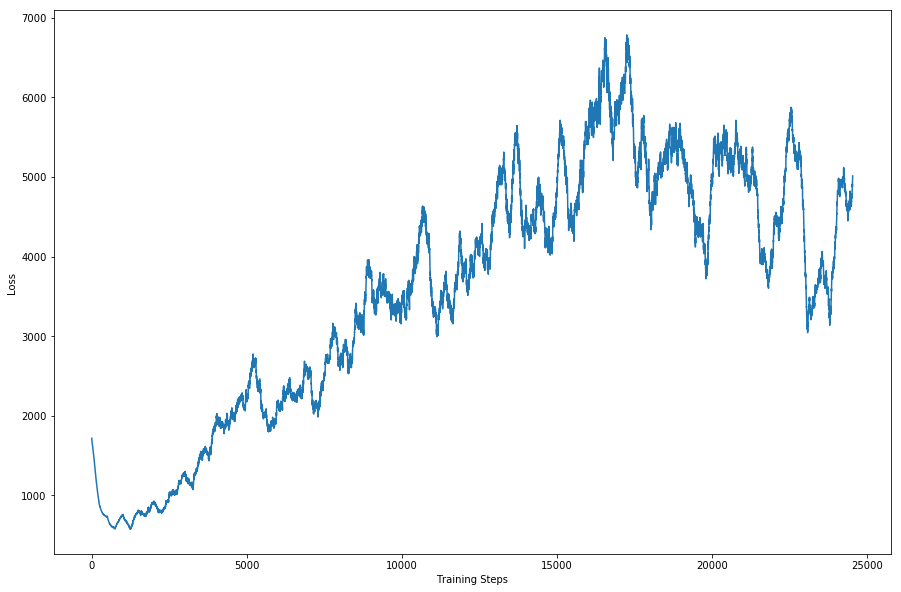

In [11]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(running_mean(losses,250))
#plt.savefig("dqn_3_loss_plot.pdf", format="pdf")